This notebook demonstrates a simple DTW based audio-score alignment on a sample of Turkish music. The content aims demostrating DTW, not providing a state-of-the-art implementation for the audio-score alignment task.

Various DTW libraries exist for Python. Here we use [the dtw-python package](https://pypi.org/project/dtw-python/).

For a detailed description of the DTW algorithm and an implementation you can refer to: 
https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S2_DTWbasic.html



In [1]:
!pip install essentia dtw-python
!pip install git+https://github.com/MTG/pycompmusic.git

     |████████████████████████████████| 13.7 MB 4.5 MB/s 
     |████████████████████████████████| 580 kB 53.8 MB/s 
  Cloning https://github.com/MTG/pycompmusic.git to /tmp/pip-req-build-1cb2uiet
  Running command git clone -q https://github.com/MTG/pycompmusic.git /tmp/pip-req-build-1cb2uiet
     |████████████████████████████████| 245 kB 7.5 MB/s 
     |████████████████████████████████| 242 kB 44.5 MB/s 
  Created wheel for pycompmusic: filename=pycompmusic-0.2+60.g8d07307-py3-none-any.whl size=116956 sha256=7ec34ecc8a74d598af4020d57a508dc05d6f4d78daecb90ea3a87427fe1fdd30
  Stored in directory: /tmp/pip-ephem-wheel-cache-9400g0q7/wheels/38/ec/b3/ccbfe99d96950dd978fb512fcb0fdc74b72e4b3d96b98e71a2
Successfully built pycompmusic
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
import json
import urllib.request
import zipfile
import os, sys,shutil
from compmusic.dunya import docserver as ds
from compmusic import dunya as dn
from essentia.standard import *


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
#This cell downloads "Turkish Makam Music Audio-Score Alignment Dataset" from
# https://zenodo.org/record/1284501#.YBaV-pMzbfY
url = 'https://zenodo.org/record/1284501/files/turkish_makam_music_audio-score_alignment_1.0.zip?download=1'
filename = 'turkish_makam_music_audio-score_alignment_1.0.zip'
print('Downloading file from ', url)
targetDir = 'score_alignment_data'
if not os.path.exists(targetDir):#creating the director
    os.mkdir(targetDir)
    
urllib.request.urlretrieve(url,filename)
#Unzipping to a specific folder
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(targetDir)
zip_ref.close()
os.remove(filename)#Removing the zip file
print('Data downloaded and unzipped to: ',targetDir)

Data downloaded and unzipped to:  score_alignment_data


In [ ]:
# Let's download the corresponding mp3 from Dunya-server
# Set your token here from https://dunya.compmusic.upf.edu/user/profile/
token = '***your token goes here ***'
dn.set_token(token)

In [ ]:
#Let's pick one of the samples in folder score_alignment_data/turkish_makam_music_audio-score_alignment_1.0/2014_fma/
mbid = '70a235be-074d-4b9b-8f94-b1860d7be887'
dataDir = 'score_alignment_data/turkish_makam_music_audio-score_alignment_1.0/2014_fma/beyati--pesrev--hafif----seyfettin_osmanoglu/'
mp3_filename = os.path.join(dataDir, '{}.mp3'.format(mbid))

# Download file if it has not been previously downloaded
if not os.path.exists(mp3_filename):
    contents = ds.file_for_document(mbid, 'mp3')
    with open(mp3_filename, 'wb') as fp:
        fp.write(contents)
    print('File downloaded: {}'.format(mp3_filename))


In [ ]:
# Reading section info to get boundaries of one of the sections 
section_info_file = os.path.join(dataDir,'{}/sectionLinks.json'.format(mbid))

f = open(section_info_file,);
section_data = json.load(f); f.close()

section_1_HANE_boundaries = section_data['annotations'][0]['time']
print('First section boundaries: ', section_1_HANE_boundaries)

First section boundaries:  [0.435299, 57.910298]


In [ ]:
def compute_pitch(filename, boundary_times):
    #Running Pitch Melodia with default parameters, extraction part of audio
    # between start_time and end_time (in seconds) stored in boundary_times list
    fs = 44100
    run_predominant_melody = PitchMelodia(sampleRate = fs)
    x = MonoLoader(filename = filename, sampleRate = fs)()
    start_ind = int(fs*boundary_times[0])
    end_ind = int(fs*boundary_times[1])
    x = x[start_ind:end_ind]
    x = EqualLoudness()(x)
    f0, confidence = run_predominant_melody(x)
    #time, f0, confidence, activation = crepe.predict(x, fs, viterbi=True)
    return f0, run_predominant_melody.paramValue('hopSize'), fs

def hz_to_midi(frequency_hz):
  return 69 + np.log2(frequency_hz/440) * 12

# Setting file names for writing analysis results
pitchFile = os.path.join(dataDir, '{}.pitch'.format(mbid))

# If pitch file exists, read it, if not run extractor and create the pitch file
if not os.path.exists(pitchFile):
    print("Computing pitch, writing output to file")
    #section_1_HANE_boundaries[0] = 0#start modified to simplify synch-visualisation
    pitchSeriesHz, hopSize, fs = compute_pitch(mp3_filename, section_1_HANE_boundaries)
    # you can use the pitch file together with SonicVisualizer to view in sync with the spectrogram of the mp3 file
    windowIndex = 0
    with open(pitchFile, 'w') as fp:
        for pitchHz in pitchSeriesHz:
            #writing timeStamp and pitch value on each row
            fp.write("{0:3.3f}\t{1:3.3f}\n".format(windowIndex * hopSize / fs, pitchHz))
            windowIndex +=1
else:
    print("Pitch files exists, reading from it")
    pitchData = np.loadtxt(pitchFile)
    timeStamps = pitchData[:,0]
    pitchSeriesHz = pitchData[:,1]


Pitch files exists, reading from it


In [ ]:
#Read score file
import codecs
score_file = 'beyati--pesrev--hafif----seyfettin_osmanoglu.txt'
score_segment_end_ind = 113#let's take the part of score corresponding to 1. HANE

with codecs.open(os.path.join(dataDir, score_file), 'r', encoding='utf-8',
                 errors='ignore') as file_reader:
  index = 0
  intervals = []
  durations = []
  for line in file_reader:
      if index > 1:#skip first two lines
          intervals.append(int(line.split('\t')[5]))
          durations.append(int(line.split('\t')[6]) / int(line.split('\t')[7]))
      index += 1
      if index >= score_segment_end_ind: 
        break


In [ ]:
#Converting lists to array and custom intervals values in the dataset to midi
durations = np.array(durations)
Hc = 1200 / 53 #Holder comma in cents
intervals_midi = np.array(intervals) * Hc / 100 #conversion formula from https://ismir2012.ismir.net/event/papers/223_ISMIR_2012.pdf

In [ ]:
#Zero values in pitch series will be problematic for alignment, let's set them to previous values
min_pitch_hz = 50
for i in range(1, pitchSeriesHz.size):
  if(pitchSeriesHz[i] < min_pitch_hz): 
    pitchSeriesHz[i] = pitchSeriesHz[i-1]

In [ ]:
num_freq_points = len(pitchSeriesHz)
freq_N_unit_dur = num_freq_points / np.sum(durations)
score_pitch_series = []
for interval_midi, duration in zip(intervals_midi, durations):
  score_pitch_series += [interval_midi] * int(np.round(duration * freq_N_unit_dur))
score_pitch_series = np.array(score_pitch_series)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


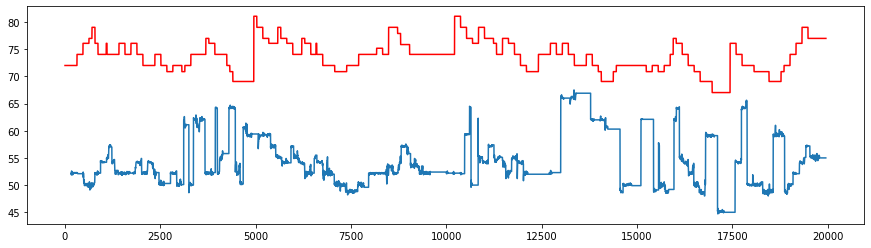

In [ ]:
pitchSeries_midi = hz_to_midi(pitchSeriesHz)

fig = plt.figure(figsize = (15, 4))
plt.plot(pitchSeries_midi)
plt.plot(score_pitch_series, 'r')

Let's pick a portion without octave errors for simplicity of this demonstration. In addition we can shift-match the melodic range

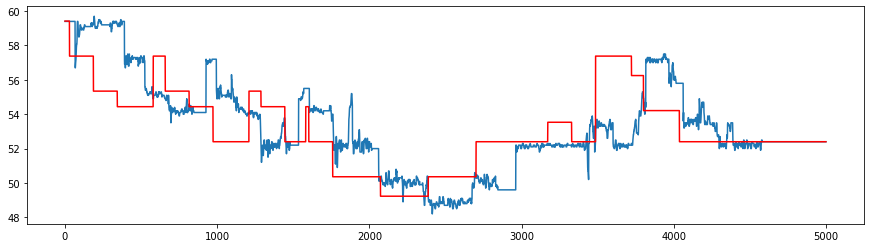

In [ ]:
series_cut_start_ind = 5000
series_cut_stop_ind = 10000
pitchSeries_midi = hz_to_midi(pitchSeriesHz[series_cut_start_ind:series_cut_stop_ind])
score_pitch_series = score_pitch_series[series_cut_start_ind:series_cut_stop_ind]
score_pitch_series -= (score_pitch_series[-1] - pitchSeries_midi[-1])

fig = plt.figure(figsize = (15, 4))
plt.plot(pitchSeries_midi)
plt.plot(score_pitch_series, 'r')

In [ ]:
alignment = dtw(pitchSeries_midi, score_pitch_series, keep_internals=True)

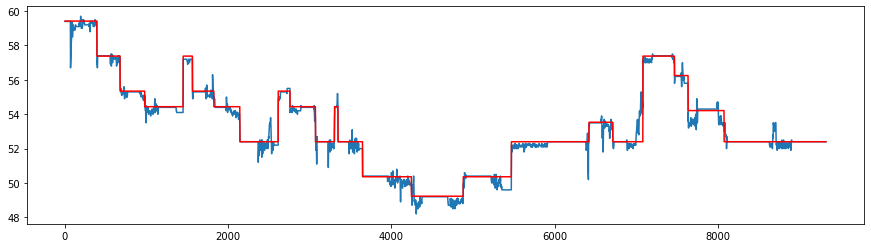

In [ ]:
score_pitch_series_aligned = score_pitch_series[alignment.index2]
pitchSeries_midi_aligned = pitchSeries_midi[alignment.index1]

fig = plt.figure(figsize = (15, 4))
plt.plot(pitchSeries_midi_aligned)
plt.plot(score_pitch_series_aligned, 'r')

In [ ]:
time = np.arange(series_cut_start_ind, series_cut_stop_ind) * hopSize / fs
aligned_time = time[alignment.index1]
#Detect boundaries from changes in synthetic f0 series, and map those indexes to real-time values
boundaries = aligned_time[np.abs(np.diff(score_pitch_series_aligned, prepend=0)) > 0]
print('Note-segment boundaries in seconds: ', boundaries)

Note-segment boundaries in seconds:  [14.51247166 15.64734694 16.03628118 16.48326531 17.2030839  17.40045351
 17.73133787 18.24217687 18.96780045 19.17387755 19.62666667 19.92562358
 19.99528345 20.49451247 21.34494331 22.27954649 23.10965986 24.51736961
 24.96435374 25.58839002 26.02956916 26.30240363 26.90321995]


For a great example of DTW alignment applied on chroma features (by  Meinard Müller and Stefan Balke), you can refer to: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3_MusicSynchronization.html